# Exploring Polynomial Features with Regularization

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plb 
%matplotlib inline

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

## Data Import & Setup

In [2]:
sf = pd.read_csv('data_files/sf_clean.csv')

# Reformatting hood_district names
sf['hood_district'] = sf['hood_district'].astype(int)
sf['hood_district'] = sf['hood_district'].astype(str)

In [3]:
sf = sf[sf['price'] < 6000]

In [4]:
laundry_dict = {'(a) in-unit': 2, 
               '(b) on-site': 1,
               '(c) no laundry': 0}

sf = sf.replace({'laundry': laundry_dict})

In [5]:
parking_dict = {'(a) valet': 3, 
               '(b) protected': 2,
               '(c) off-street': 1,
               '(d) no parking': 0}

sf = sf.replace({'parking': parking_dict})

In [6]:
pets_dict = {'(a) both': 1, 
            '(b) dogs': 1,
            '(c) cats': 1,
            '(d) no pets': 0}

sf = sf.replace({'pets': pets_dict})

In [7]:
sf = sf.drop(['housing_type'], axis=1)

In [8]:
sf = pd.get_dummies(sf)
sf = sf.drop(['hood_district_10'], axis=1)

## Train / Test Split

In [10]:
X, y = sf.drop('price',axis=1), sf['price']

# Training versus Test Data
# hold out 20% of the data for testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=5)

# Training versus Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=3)

## Polynomial Features Set Up

In [11]:
poly = PolynomialFeatures(degree=2, interaction_only=False)
    
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

In [12]:
# Scaling for Ridge & Lasso 
scaler = StandardScaler(with_mean=False)

X_train_scaled = scaler.fit_transform(X_train_poly)
X_val_scaled = scaler.transform(X_val_poly)
X_test_scaled = scaler.transform(X_test_poly)

## Lasso

In [13]:
alphavec = 10**np.linspace(-2,1,10000)

lasso_model = LassoCV(alphas=alphavec, cv=3).fit(X_train_scaled, y_train)

In [14]:
las_alpha = lasso_model.alpha_
las_alpha

5.734239758366275

In [15]:
las = Lasso(alpha=las_alpha)

las.fit(X_train_scaled, y_train)
print(f'Lasso Regression train R^2: {las.score(X_train_scaled, y_train):.5f}')
print(f'Lasso Regression val R^2: {las.score(X_val_scaled, y_val):.5f}')
print("")
print(f'Lasso Regression RMSE (train): {mean_squared_error(y_train, las.predict(X_train_scaled), squared=False):.5f}')
print(f'Lasso Regression RMSE (val): {mean_squared_error(y_val, las.predict(X_val_scaled), squared=False):.5f}')

Lasso Regression train R^2: 0.79619
Lasso Regression val R^2: 0.80229

Lasso Regression RMSE (train): 461.59090
Lasso Regression RMSE (val): 477.59814


## Ridge

In [16]:
alphavec = 10**np.linspace(-2,2,500)

ridge_model = RidgeCV(alphas=alphavec, cv=3)
ridge_model.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.01862899e-02, 1.03760502e-02, 1.05693455e-02,
       1.07662418e-02, 1.09668060e-02, 1.11711065e-02, 1.13792129e-02,
       1.15911962e-02, 1.18071285e-02, 1.20270833e-02, 1.22511358e-02,
       1.24793621e-02, 1.27118400e-02, 1.29486487e-02, 1.31898690e-02,
       1.34355829e-02, 1.36858742e-02, 1.39408283e-02, 1.42005318e-02,
       1.44650734e-02, 1.47345431e-0...
       6.54080591e+01, 6.66265452e+01, 6.78677305e+01, 6.91320378e+01,
       7.04198979e+01, 7.17317494e+01, 7.30680395e+01, 7.44292233e+01,
       7.58157646e+01, 7.72281357e+01, 7.86668179e+01, 8.01323013e+01,
       8.16250851e+01, 8.31456781e+01, 8.46945981e+01, 8.62723729e+01,
       8.78795401e+01, 8.95166472e+01, 9.11842520e+01, 9.28829225e+01,
       9.46132376e+01, 9.63757866e+01, 9.81711702e+01, 1.00000000e+02]),
        cv=3)

In [17]:
rid_alpha = ridge_model.alpha_
rid_alpha

11.326825671361538

In [18]:
rid = Ridge(alpha=rid_alpha)

rid.fit(X_train_scaled, y_train)
print(f'Ridge Regression train R^2: {rid.score(X_train_scaled, y_train):.5f}')
print(f'Ridge Regression val R^2: {rid.score(X_val_scaled, y_val):.5f}')
print("")
print(f'Ridge Regression RMSE (train): {mean_squared_error(y_train, rid.predict(X_train_scaled), squared=False):.5f}')
print(f'Ridge Regression RMSE (val): {mean_squared_error(y_val, rid.predict(X_val_scaled), squared=False):.5f}')

Ridge Regression train R^2: 0.80931
Ridge Regression val R^2: 0.80943

Ridge Regression RMSE (train): 446.49028
Ridge Regression RMSE (val): 468.89194


## Cross Validation & Comparison

In [53]:
sf2 = sf.copy()

In [59]:
X, y = sf2.drop('price',axis=1), sf2['price']

# Training versus Test Data
# hold out 20% of the data for testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=7)

In [60]:
kf = KFold(n_splits=3, shuffle=True, random_state = 12)

cv_rid_train_r2s, cv_las_train_r2s = [], []
cv_rid_val_r2s, cv_las_val_r2s = [], []

rid_rmses_train, las_rmses_train = [], []
rid_rmses_val, las_rmses_val = [], []

X_kf, y_kf = np.array(X), np.array(y)

for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
    
    # Set up poly features
    poly = PolynomialFeatures(degree=2, interaction_only=False)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Scaling for Ridge & Lasso 
    scaler = StandardScaler(with_mean=False)
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_val_scaled = scaler.transform(X_val_poly)
    
    # Lasso
    las = Lasso(alpha=las_alpha)
    las.fit(X_train_scaled, y_train)
    
    cv_las_train_r2s.append(las.score(X_train_scaled, y_train))
    cv_las_val_r2s.append(las.score(X_val_scaled, y_val))
    las_rmses_train.append(mean_squared_error(y_train, las.predict(X_train_scaled), squared=False))
    las_rmses_val.append(mean_squared_error(y_val, las.predict(X_val_scaled), squared=False))
    
    # Ridge
    rid = Ridge(alpha=rid_alpha)
    rid.fit(X_train_scaled, y_train)
    
    cv_rid_train_r2s.append(rid.score(X_train_scaled, y_train))
    cv_rid_val_r2s.append(rid.score(X_val_scaled, y_val))
    rid_rmses_train.append(mean_squared_error(y_train, rid.predict(X_train_scaled), squared=False))
    rid_rmses_val.append(mean_squared_error(y_val, rid.predict(X_val_scaled), squared=False))

# Summary output

print("Ridge")
print(f'Ridge mean cv r^2 (TRAIN): {np.mean(cv_rid_train_r2s):.5f} +- {np.std(cv_rid_train_r2s):.5f}')
print(f'Ridge mean cv r^2 (VAL): {np.mean(cv_rid_val_r2s):.5f} +- {np.std(cv_rid_val_r2s):.5f}')
print(f'Ridge mean RMSE (TRAIN): {np.mean(rid_rmses_train):.5f} +- {np.std(rid_rmses_train):.3f}')
print(f'Ridge mean RMSE (VAL): {np.mean(rid_rmses_train):.5f} +- {np.std(rid_rmses_train):.3f}')
print('')
print("Lasso")
print(f'Lasso mean cv r^2 (TRAIN): {np.mean(cv_las_train_r2s):.5f} +- {np.std(cv_las_train_r2s):.5f}')
print(f'Lasso mean cv r^2 (VAL): {np.mean(cv_las_val_r2s):.5f} +- {np.std(cv_las_val_r2s):.5f}')
print(f'Lasso mean RMSE (VAL): {np.mean(las_rmses_train):.5f} +- {np.std(las_rmses_train):.5f}')
print(f'Lasso mean RMSE (VAL): {np.mean(las_rmses_val):.5f} +- {np.std(las_rmses_val):.5f}')    

Ridge
Ridge mean cv r^2 (TRAIN): 0.82109 +- 0.00713
Ridge mean cv r^2 (VAL): 0.74502 +- 0.02631
Ridge mean RMSE (TRAIN): 436.30961 +- 0.555
Ridge mean RMSE (VAL): 436.30961 +- 0.555

Lasso
Lasso mean cv r^2 (TRAIN): 0.80923 +- 0.00777
Lasso mean cv r^2 (VAL): 0.74903 +- 0.02354
Lasso mean RMSE (VAL): 450.53753 +- 0.40695
Lasso mean RMSE (VAL): 514.89685 +- 4.78496


In [23]:
rid_coefs = rid.coef_
las_coefs = las.coef_

features = sf2.columns[1:]

coef_data = {'Features': poly.get_feature_names(X.columns),
             'Ridge': rid_coefs,
             'Lasso': las_coefs}

coef_df = pd.DataFrame(coef_data)

In [156]:
coef_df[:50]

,Features,Ridge,Lasso
0,1,0.000000,0.000000
1,sqft,390.883489,542.753295
2,beds,200.936262,154.193513
3,bath,147.969036,59.462371
4,laundry,32.703654,0.000000
5,pets,21.234292,0.000000
6,parking,-65.906871,0.000000
7,hood_district_1,7.258444,0.000000
8,hood_district_2,-19.554596,-0.000000
9,hood_district_3,1.605437,0.000000


In [157]:
coef_df[50:100]

,Features,Ridge,Lasso
50,bath hood_district_2,26.042538,26.902979
51,bath hood_district_3,27.504737,0.000000
52,bath hood_district_4,27.347132,1.303150
53,bath hood_district_5,74.734820,51.239106
54,bath hood_district_6,62.494798,47.712962
55,bath hood_district_7,-37.476625,0.000000
56,bath hood_district_8,-11.626175,0.000000
57,bath hood_district_9,147.710425,135.910046
58,laundry^2,89.042503,85.424930
59,laundry pets,-34.355514,-0.000000


In [158]:
coef_df[100:]

,Features,Ridge,Lasso
100,hood_district_2^2,-19.554596,-0.000000
101,hood_district_2 hood_district_3,0.000000,0.000000
102,hood_district_2 hood_district_4,0.000000,0.000000
103,hood_district_2 hood_district_5,0.000000,0.000000
104,hood_district_2 hood_district_6,0.000000,0.000000
105,hood_district_2 hood_district_7,0.000000,0.000000
106,hood_district_2 hood_district_8,0.000000,0.000000
107,hood_district_2 hood_district_9,0.000000,0.000000
108,hood_district_3^2,1.605437,0.000000
109,hood_district_3 hood_district_4,0.000000,0.000000


# RIDGE: Full Train and Test

In [61]:
poly = PolynomialFeatures(degree=2, interaction_only=False)
    
X_train_poly = poly.fit_transform(X)
X_test_poly = poly.transform(X_test)

# Scaling for Ridge & Lasso 
scaler = StandardScaler(with_mean=False)

X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

In [62]:
rid = Ridge(alpha=rid_alpha)
rid.fit(X_train_scaled, y)

Ridge(alpha=11.326825671361538)

In [63]:
print("Ridge - training score: ", rid.score(X_train_scaled, y))
print("Rige - test score: ", rid.score(X_test_scaled, y_test))
print("")
print("RMSE - training: ", mean_squared_error(y, rid.predict(X_train_scaled), squared=False))
print("RMSE - test: ", mean_squared_error(y_test, rid.predict(X_test_scaled), squared=False))

Ridge - training score:  0.8122510336536014
Rige - test score:  0.7679796498598968

RMSE - training:  447.40418921833856
RMSE - test:  494.20688730478724


In [65]:
rid_predict = rid.predict(X_test_scaled)

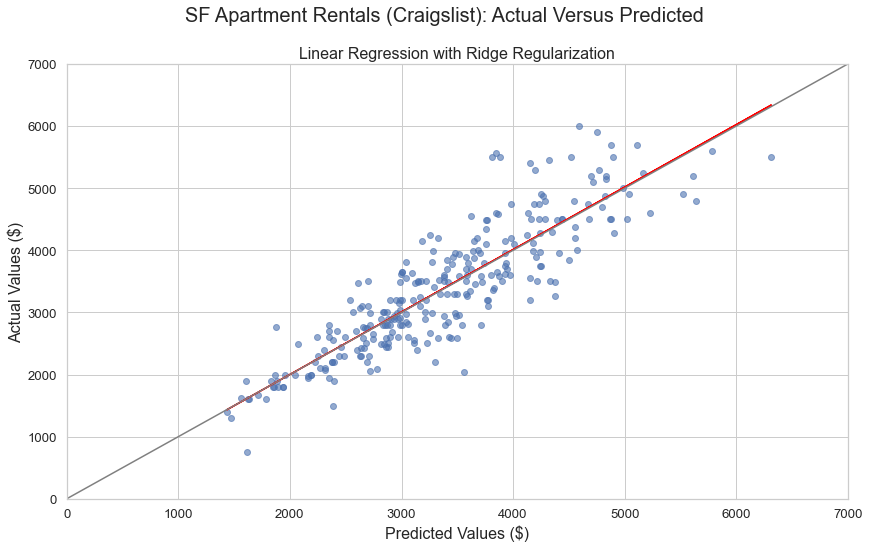

In [212]:
plt.figure(figsize=(14, 8))
plt.scatter(rid_predict, y_test, alpha=.6) 

z = np.polyfit(rid_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(rid_predict, p(rid_predict), 'm-', color='red')
plt.plot(np.linspace(0,7000,1000), np.linspace(0,7000,1000), color='grey')

plt.xlim(0, 7000)
plt.ylim(0, 7000)

plt.suptitle('SF Apartment Rentals (Craigslist): Actual Versus Predicted', fontsize=20, fontname='Arial')
plt.title('Linear Regression with Ridge Regularization', fontsize=16, fontname='Arial')
plt.xlabel('Predicted Values ($)', fontsize=16, fontname='Arial')
plt.ylabel('Actual Values ($)', fontsize=16, fontname='Arial');

#plt.savefig('img/ridge_actual_predicted.png');

In [67]:
rid_residual = (y_test - rid_predict)

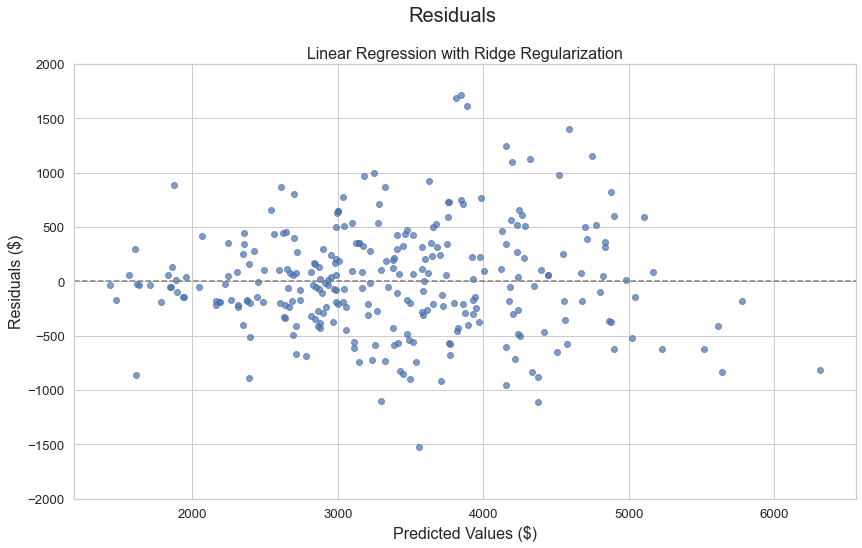

In [210]:
plt.figure(figsize=(14, 8))
plt.scatter(rid_predict, rid_residual, alpha=.7)   

plt.axhline(0, linestyle='--', color='grey')
plt.suptitle('Residuals', fontsize=20, fontname='Arial')
plt.title('Linear Regression with Ridge Regularization', fontsize=16, fontname='Arial')
plt.ylim(-2000, 2000)
plt.xlabel('Predicted Values ($)', fontsize=16, fontname='Arial')
plt.ylabel('Residuals ($)', fontsize=16, fontname='Arial');

#plt.savefig('img/ridge_residuals.png');

# Stats Models

In [173]:
rid_alpha

11.326825671361538

In [213]:
x_train = sm.add_constant(X_train_scaled)
x_test = sm.add_constant(X_test_scaled)

ols_mod = sm.OLS(y, x_train)
model = ols_mod.fit_regularized(method='elastic_net', L1_wt=0, alpha=rid_alpha)
ypred = model.predict(x_test)

In [214]:
model.summary()

NotImplementedError: 

In [182]:
#print("Statsmodels - training score: ", rid.score(x, y))
#print("Statsmodels - test score: ", rid.score(X_test_scaled, y_test))
print("")
#print("RMSE - training: ", mean_squared_error(y, model.predict(X_train), squared=False))
print("RMSE - test: ", mean_squared_error(y_test, ypred, squared=False))


RMSE - test:  941.4140123288622


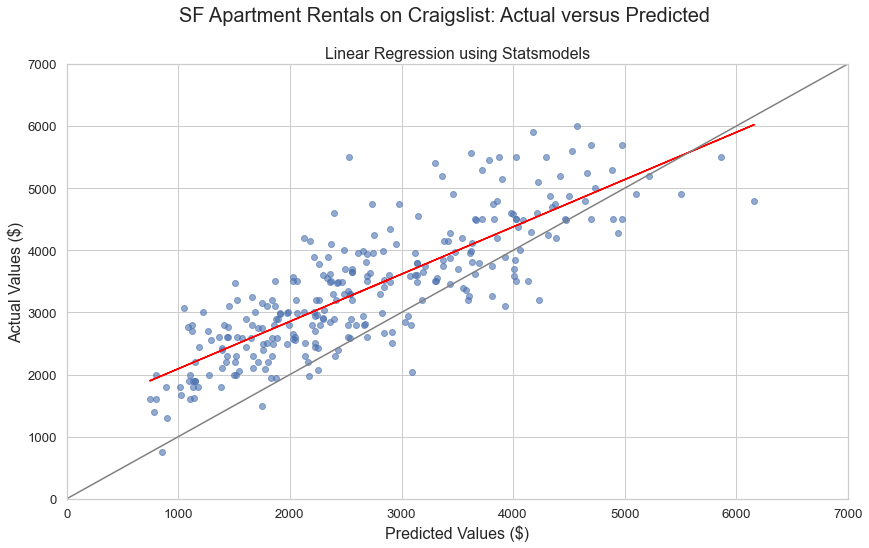

In [189]:
plt.figure(figsize=(14, 8))
plt.scatter(ypred, y_test, alpha=.6)

z = np.polyfit(ypred, y_test, 1)
p = np.poly1d(z)
plb.plot(ypred, p(ypred), 'm-', color='red')
plt.plot(np.linspace(0,7000,1000), np.linspace(0,7000,1000), color='grey')

plt.xlim(0, 7000)
plt.ylim(0, 7000)

plt.suptitle('SF Apartment Rentals on Craigslist: Actual versus Predicted', fontsize=20, fontname='Arial')
plt.title('Linear Regression using Statsmodels', fontsize=16, fontname='Arial')
plt.xlabel('Predicted Values ($)', fontsize=16, fontname='Arial')
plt.ylabel('Actual Values ($)', fontsize=16, fontname='Arial');

#plt.savefig('img/sm_actual_predicted.png');

In [89]:
sm_residuals = (y_test - ypred)

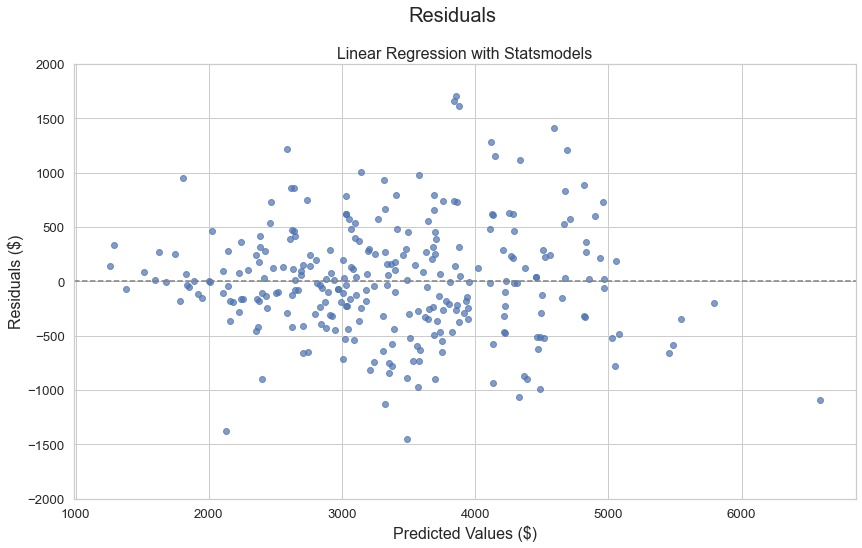

In [135]:
plt.figure(figsize=(14, 8))
plt.scatter(ypred, sm_residuals, alpha=.7)   

plt.axhline(0, linestyle='--', color='grey')
plt.suptitle('Residuals', fontsize=20, fontname='Arial')
plt.title('Linear Regression with Statsmodels', fontsize=16, fontname='Arial')
plt.ylim(-2000, 2000)
plt.xlabel('Predicted Values ($)', fontsize=16, fontname='Arial')
plt.ylabel('Residuals ($)', fontsize=16, fontname='Arial');

#plt.savefig('img/sm_residuals.png');

# More Charts

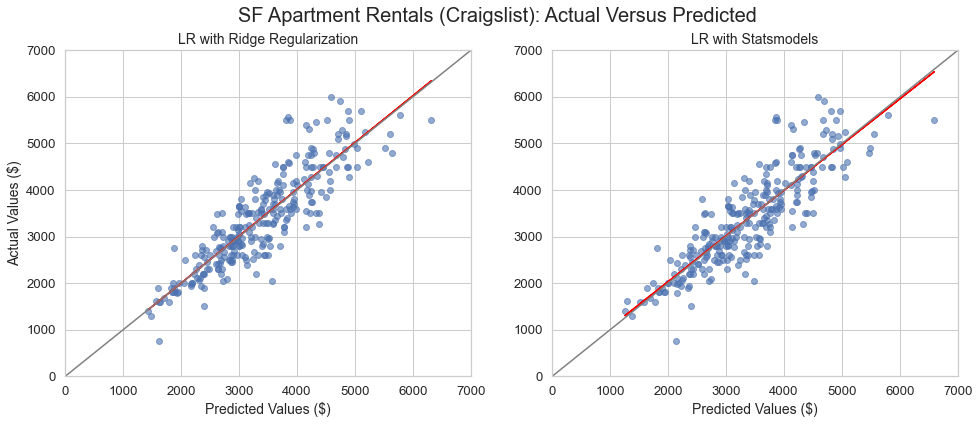

In [138]:
plt.figure(figsize=(16, 6))
plt.suptitle('SF Apartment Rentals (Craigslist): Actual Versus Predicted', fontsize=20, fontname='Arial')

# Plot 1 - ridge
plt.subplot(1, 2, 1)
plt.scatter(rid_predict, y_test, alpha=.6) 

z = np.polyfit(rid_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(rid_predict, p(rid_predict), 'm-', color='red')
plt.plot(np.linspace(0,7000,1000), np.linspace(0,7000,1000), color='grey')

plt.xlim(0, 7000)
plt.ylim(0, 7000)

plt.title('LR with Ridge Regularization', fontsize=14, fontname='Arial')
plt.xlabel('Predicted Values ($)', fontsize=14, fontname='Arial')
plt.ylabel('Actual Values ($)', fontsize=14, fontname='Arial')

# Plot 2
plt.subplot(1, 2, 2)
plt.scatter(ypred, y_test, alpha=.6)

z = np.polyfit(ypred, y_test, 1)
p = np.poly1d(z)
plb.plot(ypred, p(ypred), 'm-', color='red')
plt.plot(np.linspace(0,7000,1000), np.linspace(0,7000,1000), color='grey')

plt.xlim(0, 7000)
plt.ylim(0, 7000)

plt.title('LR with Statsmodels', fontsize=14, fontname='Arial')
plt.xlabel('Predicted Values ($)', fontsize=14, fontname='Arial');

#plt.savefig('img/act_pred_compare.png')

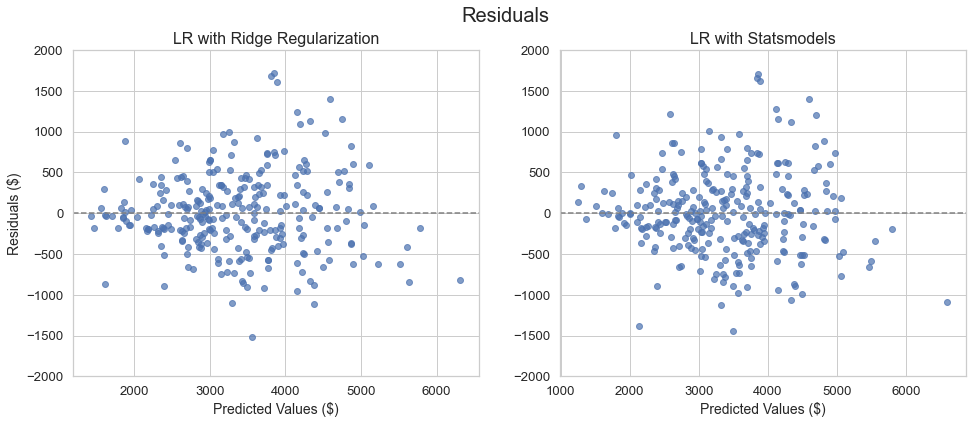

In [140]:
plt.figure(figsize=(16, 6))
plt.suptitle('Residuals', fontsize=20, fontname='Arial')

# Plot 1 - ridge
plt.subplot(1, 2, 1)
plt.scatter(rid_predict, rid_residual, alpha=.7)   
plt.axhline(0, linestyle='--', color='grey')
plt.title('LR with Ridge Regularization', fontsize=16, fontname='Arial')
plt.ylim(-2000, 2000)
plt.xlabel('Predicted Values ($)', fontsize=14, fontname='Arial')
plt.ylabel('Residuals ($)', fontsize=14, fontname='Arial')

# Plot 2 - sm
plt.subplot(1, 2, 2)
plt.scatter(ypred, sm_residuals, alpha=.7)   
plt.axhline(0, linestyle='--', color='grey')
plt.title('LR with Statsmodels', fontsize=16, fontname='Arial')
plt.ylim(-2000, 2000)
plt.xlabel('Predicted Values ($)', fontsize=14, fontname='Arial');

#plt.savefig('img/residuals_compare.png')

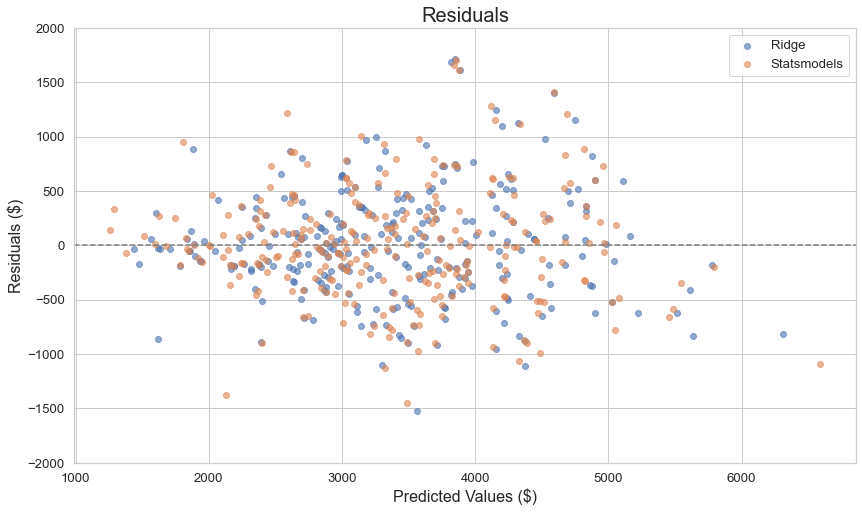

In [142]:
plt.figure(figsize=(14, 8))
plt.scatter(rid_predict, rid_residual, alpha=.6)  
plt.scatter(ypred, sm_residuals, alpha=.6)   
plt.axhline(0, linestyle='--', color='grey', label='_nolegend_')
plt.title('Residuals', fontsize=20, fontname='Arial')
plt.ylim(-2000, 2000)
plt.xlabel('Predicted Values ($)', fontsize=16, fontname='Arial')
plt.ylabel('Residuals ($)', fontsize=16, fontname='Arial')
plt.legend(['Ridge', 'Statsmodels']);

#plt.savefig('img/residuals_compare_2.png')

In [144]:
mae = np.mean(np.abs(ypred - y_test))
mae

386.2700840211029

In [145]:
mae = np.mean(np.abs(rid_predict - y_test))
mae

377.3883786446563

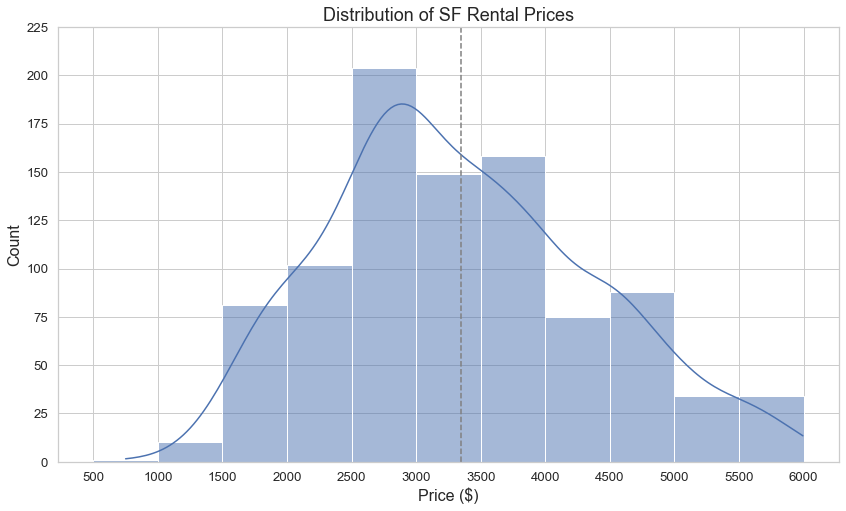

In [132]:
plt.figure(figsize=(14, 8))
ax_actual = sns.histplot(sf.price, kde=True, bins=(list(range(500, 6001, 500))))
plt.axvline(sf.price.mean(), linestyle='--', color='grey')
#ax_predict = sns.histplot(rid_predict, kde=True)
ax_actual.set_title('Distribution of SF Rental Prices', fontname='Arial', fontsize=18)
ax_actual.set_xlabel('Price ($)', fontname='Arial', fontsize=16)
ax_actual.set_ylabel('Count', fontname='Arial', fontsize=16)
ax_actual.set_yticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225])
ax_actual.set_xticks(list(range(500, 6001, 500)))
ax_actual.set_xticklabels(list(range(500, 6001, 500)));

#plt.savefig('img/price_distribution.png');